# FASHION MNIST EXAMPLE CLASSIFICATION USING PYTORCH###

FROM: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy/notebook

# **Importing Important Libraries**

import numpy, pandas, matplotlib, torch, torch.nn, torch.autograd as Variable, also torchvision, torchvision(transforms), Dataset and Dataloader, and confusion matrix from sklearn.metrics.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### If the GPU is available use it for the computation otherwise use the CPU.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Using FashionMNIST class from torchvision module.


*   It will download the dataset first time, train=False for test_set and transform to tensor the input images. Define train_set and test_set




In [5]:
train_set = torchvision.datasets.FashionMNIST("/data", download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("/data", download = True,train=False, transform = transforms.Compose([transforms.ToTensor()]))


Then generate the train_loader and test_loader using Dataloader, and a batch_size of 100

In [6]:
train_loader = DataLoader(train_set,batch_size = 100)
test_loader = DataLoader(test_set,batch_size = 100)

### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



> The method is names 'output_label', and is a mapping between numbers and labels:
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"



> add this so input is what is expected: "input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]"








In [7]:
def output_label(label):
  label_mapping = {
                  0: "T-shirt/Top",
                  1: "Trouser",
                  2: "Pullover",
                  3: "Dress",
                  4: "Coat",
                  5: "Sandal",
                  6: "Shirt",
                  7: "Sneaker",
                  8: "Bag",
                  9: "Ankle Boot"
  }

  input=(label.item() if type(label) == torch.Tensor else label)
  return label_mapping[input]

### Playing with data and displaying some images using matplotlib imshow() method.

Get first item in train_dataloader, show its size. Plot size of training set, and also show the image and label for first item in train_dataloader, also show batch



In [8]:
image,label = next(iter(train_loader))

In [9]:
image[0].size(), label[0].size()

(torch.Size([1, 28, 28]), torch.Size([]))

In [10]:
len(train_set), len(test_set)


(60000, 10000)

Text(0.5, 1.0, 'Ankle Boot')

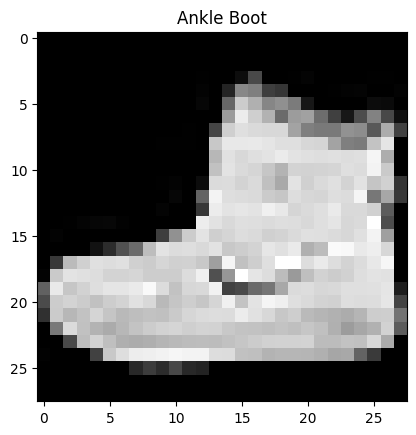

In [11]:
image,label = next(iter(train_set))
plt.imshow(image[0].squeeze(),cmap="gray")
plt.title(output_label(label))

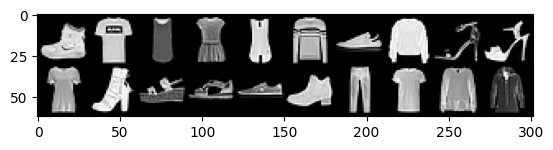

In [12]:
grid_loader = DataLoader(train_set, batch_size = 20)
batch = next(iter(grid_loader))
images,labels = batch


grid = torchvision.utils.make_grid(images, nrow = 10)
plt.imshow(np.transpose(grid, (1,2,0)))

## Building a CNN


*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

> Lets implementing the network...





In [13]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.seqlayer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),#1x28x28 -> 32x28x28
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)#32x28x28 -> 32x14x14
    )
    self.drop = nn.Dropout2d(p=0.25)
    self.seqlayer2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 0),#32x14x14 -> 64x12x12
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)#64x12x12 -> 64x6x6
    )
    self.flatten = nn.Flatten()
    self.lastlayer = nn.Sequential(
        nn.Linear(in_features = 64*6*6, out_features= 600),
        nn.ReLU(),
        nn.Linear(in_features = 600, out_features = 120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features = 10)
    )

  def forward(self,x):
    x = self.seqlayer1(x)
    x = self.drop(x)
    x = self.seqlayer2(x)
    x = self.flatten(x)
    x = self.lastlayer(x)
    return x


### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purposes, and use learning reate of 0.001
* Print the model



In [14]:
model = FashionCNN()
model.to(device)

lossfc = nn.CrossEntropyLoss()
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)


FashionCNN(
  (seqlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.25, inplace=False)
  (seqlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lastlayer): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
  )
)


## Training a network and Testing it on test dataset



*   5 epochs
*   Generate lists for loss, iteration and accuracy (for visualization)
*   Also predictions list and labels list
* Start loop over epochs:
  *   Loop over mini-batches in train_loader (count mini-batch iterations)
    *   transfer images and labels to device
    *   shape mini-batch in expected tensor format
    *   Do forward pass
    *   Compute loss from error (crossentropyloss)
    *   Set gradients to 0 for current batch
    *   Backrpropragate error
    *   Optimize the parameters (step)
  *   If iteration % 50 == 0
    *   Iterate over the batches of images and labels in the test data loader.
    *   Move the images and labels to the specified device
    *   Append the true labels to the labels_list for future use
    *   Pass the test images through the model to get the predicted outputs
    *   Extract the predicted labels by taking the index of the maximum value along the appropriate axis and move them to the device
    *   Append the predicted labels to predictions_list
    *   Calculate the number of correct predictions by summing the number of correct matches between predicted and true labels
    *   Increment the total count by the number of labels in the batch
    *   Calculate the accuracy as the percentage of correct predictions over the total number of samples
    *   Store metrics: Append the loss value to loss_list, current iteration count to iteration_list, accuracy to accuracy_list
  *   If iteration % 500 == 0
    *   print the iteration count, loss, and accuracy

In [15]:
# num_epochs = 5
# count = 0
# # Lists for visualization of loss and accuracy
# loss_list = []
# iteration_list = []
# accuracy_list = []

# # Lists for knowing classwise accuracy
# predictions_list = []
# labels_list = []

# for epoch in range(num_epochs):
#     for images, labels in train_loader:
#         # Transfering images and labels to GPU if available
#         images, labels = images.to(device), labels.to(device)


#         # Forward pass
#         outputs = model(images)
#         loss = lossfc(outputs, labels)

#         # Initializing a gradient as 0 so there is no mixing of gradient among the batches
#         optimizer.zero_grad()

#         #Propagating the error backward
#         loss.backward()

#         # Optimizing the parameters
#         optimizer.step()

#         count += 1

#     # Testing the model

#         if not (count % 50):    # It's same as "if count % 50 == 0"
#             total = 0
#             correct = 0

#             for images, labels in test_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 labels_list.append(labels)

#                 outputs = model(images)

#                 predictions = torch.max(outputs, 1)[1].to(device)
#                 predictions_list.append(predictions)
#                 correct += (predictions == labels).sum()

#                 total += len(labels)

#             accuracy = correct * 100 / total
#             loss_list.append(loss.data)
#             iteration_list.append(count)
#             accuracy_list.append(accuracy)

#         if not (count % 500):
#             print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

In [16]:
Nepochs = 10
counter = 0
list_loss_train = []
list_loss_test = []
list_iteration = []
list_accuracy_train = []
list_accuracy_test = []

list_predictions = []
list_labels = []

for epoch in range(Nepochs):
  for i, data in enumerate(train_loader,0):
    image_batch, label_batch = data[0].to(device), data[1].to(device)

    outputs = model(image_batch) #forward pass
    loss = lossfc(outputs, label_batch)#compute loss

    optimizer.zero_grad() #set gradients to 0

    loss.backward() #Backpropagate

    optimizer.step() #update parameters

    counter += 1

    if (counter % 50 == 0): #Test the model on test data
      total = 0
      correct = 0
      with torch.no_grad():
        for images,labels in test_loader:
          images,labels = images.to(device),labels.to(device)

          list_labels.append(labels)
          outputs = model(images)
          predictions = torch.max(outputs,1)[1].to(device)
          list_predictions.append(predictions)

          correct = correct + (predictions == labels).sum()

          total = total + len(labels)

        accuracy = correct * 100 / total

        list_loss_test.append(loss.data)
        list_iteration.append(counter)
        list_accuracy_test.append(accuracy)

    if (counter % 500 == 0):
      print("Iter: {}, Test Loss: {}, Accuracy: {}%". format(counter, loss.data, accuracy))








Iter: 500, Test Loss: 0.4307752549648285, Accuracy: 88.3499984741211%
Iter: 1000, Test Loss: 0.3096330165863037, Accuracy: 89.05999755859375%
Iter: 1500, Test Loss: 0.1983519047498703, Accuracy: 88.07999420166016%
Iter: 2000, Test Loss: 0.22980928421020508, Accuracy: 90.66999816894531%
Iter: 2500, Test Loss: 0.141336128115654, Accuracy: 90.72999572753906%
Iter: 3000, Test Loss: 0.1371636539697647, Accuracy: 90.29999542236328%


### Visualizing the Loss and Accuracy with Iterations
plot iterations vs loss and iterations vs accuracy

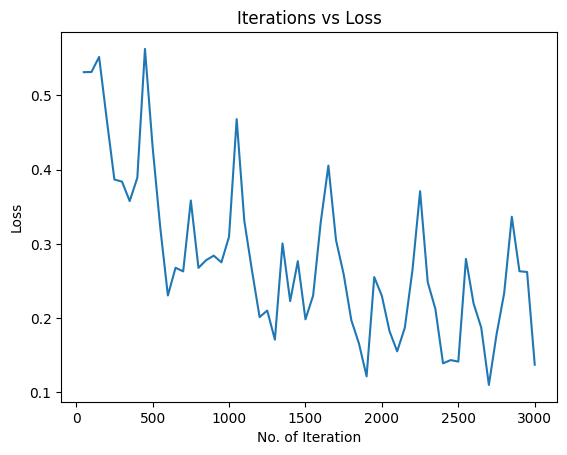

In [27]:
plt.plot(list_iteration, [loss.cpu().numpy() for loss in list_loss_test])
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss(test)")
plt.show()

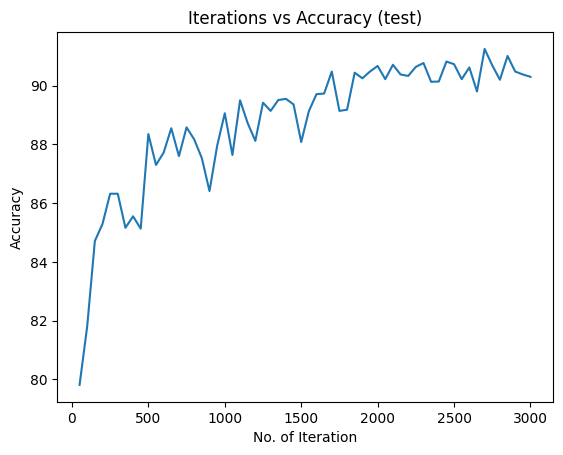

In [28]:
plt.plot(list_iteration, [loss.cpu().numpy() for loss in list_accuracy_test])
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy (test)")
plt.show()

### Looking the Accuracy in each class of FashionMNIST dataset

run over mini-batches in test_loader, run model and save output.

### Printing the Confusion Matrix

get list from the predictions_lsit and labels_list. use sklearns' confusion_matrix to plot it